In [5]:
!pip install fastai
!pip install fastinference
!pip install shap

In [6]:
import torch, numpy as np, pandas as pd
from fastai.tabular.all import *

## A simple baseline model to identify macrophages in a scRNA-seq dataset

We will use a single-cell RNA seq dataset [GSE115978](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE115978) containing 7186 cells of 10 different immune and malignant types including macrophages. The dataset can be explored in [Hegemon](http://hegemon.ucsd.edu/~rohan/Hegemon/explore.php?id=M1&A=TYROBP&B=FCER1G).

This dataset was originally used to [study](https://pubmed.ncbi.nlm.nih.gov/30388455/) immune response to melanoma cancer. It was used by [Andreatta et al.](https://academic.oup.com/bioinformatics/article/38/9/2642/6544581#401764345) to show their algorithm scGate to classify cell types in single-cell data.

![picture](https://drive.google.com/uc?id=1z2o8qJNVBA6YZWa13gWVJEn2tkXMAYMV)

Here, we train a simple feed-forward neural network on a subset of the single-cell data to recognize macrophages and other cell types.

The gold standard is to develop a model that can identify macrophages in other datasets, across platforms and species.

### Read Data

In [7]:
df = pd.read_pickle("../Data/GSE115978-allData.pkl")
macrophage = (df["cellType"] == "Macrophage")
df.insert(2, "macrophage", macrophage)
df

,cellID,cellType,macrophage,C9orf152,RPS11,ELMO2,CREB3L1,PNMA1,MMP2,TMEM216,...,MIR4691,GPLD1,RAB8A,RXFP2,PCIF1,PIK3IP1,SNRPD2,SLC39A6,CTSC,AQP7
0,GSM3197115,Mal,False,0.0,2.067933,1.517847,0.0,1.686722,1.168448,1.526162,...,0.000000,0.367588,1.496530,0.0,0.000000,0.966075,1.876721,1.638426,1.512449,0.0
1,GSM3197116,Mal,False,0.0,1.922102,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.802701,1.909713,0.000000,0.000000,0.000000,0.0
2,GSM3197117,Mal,False,0.0,2.015497,0.841959,0.0,0.695306,0.000000,0.000000,...,0.000000,1.127459,0.000000,0.0,0.000000,0.000000,1.882266,1.141858,1.459023,0.0
3,GSM3197118,Mal,False,0.0,1.930309,1.691069,0.0,1.592092,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.947145,1.666798,1.047136,0.0
4,GSM3197119,Mal,False,0.0,2.058619,1.509809,0.0,1.748345,1.676507,1.527963,...,0.000000,0.624097,1.686261,0.0,1.601311,1.379246,1.924609,1.715210,1.352315,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7181,GSM3204296,T.CD8,False,0.0,1.924485,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.617210,1.937055,0.0,0.000000,0.000000,1.986266,0.000000,1.991558,0.0
7182,GSM3204297,T.CD8,False,0.0,1.977320,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.636619,0.000000,0.0,1.941190,1.212302,0.000000,0.000000,1.324604,0.0
7183,GSM3204298,T.CD8,False,0.0,1.986248,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.868394,0.000000,0.0,1.997277,0.000000,0.000000,0.000000,1.601028,0.0
7184,GSM3204299,T.CD8,False,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,1.868568,1.488624,0.000000,0.0,0.000000,0.000000,1.668218,0.000000,1.948110,0.0


We can see what cell types are present in the data.

<AxesSubplot: >

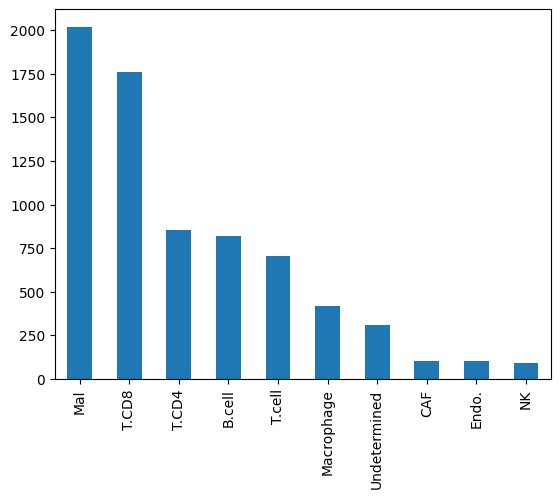

In [8]:
df['cellType'].value_counts().plot(kind="bar")

In [9]:
df.shape

(7186, 21593)

We also see that the dataset is highly imbalanced. There are 7186 single cells in the dataset, of which 420 are macrophages (5.8%). Cell type is the target and we have 21590 columns that can act as features (genes).

### MLP with all genes as features

We can use the fastai library to train a simple feed-forward neural network, though with many abstractions in the code.

First, we can split the dataframe into training and validation sets, by default into 20% and 80%.

#### Define training and validation split

In [10]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, 3:].reset_index() # Input features
y = df["macrophage"]  # Output target
X_train, X_val, y_train, y_val = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.2, \
                                                  stratify=y, random_state=21)

In [11]:
train_idx = X_train[:,0].astype(int)
val_idx = X_val[:,0].astype(int)
splits = (L(train_idx.tolist()), L(val_idx.tolist()))

#### Model parameters

In [12]:
EPOCHS = 2
BATCH_SIZE = 64
LEARNING_RATE = 0.01
NUM_FEATURES = len(X.columns)-1
NUM_CLASSES = 2

#### Dataloaders

In [13]:
# Define a DataLoaders object to feed data into the model, batch size 64
dls = TabularPandas(
    df, splits=splits,
    cont_names=list(df.columns[3:]),
    y_names='macrophage',
    y_block = CategoryBlock(),
).dataloaders(path=".", bs=BATCH_SIZE)

In [22]:
# Initialize the model
F1_Score= F1Score()
learn = tabular_learner(dls, metrics=[accuracy, F1_Score], layers=[100,100])

#### Tune learning rate

SuggestedLRs(slide=0.0691830962896347, valley=0.002511886414140463)

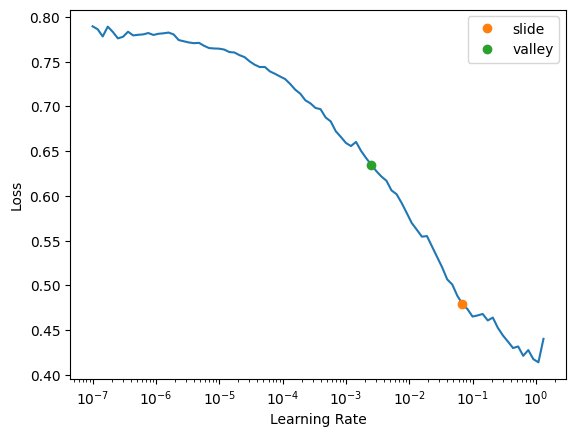

In [15]:
# Identify appropriate learning rate
learn.lr_find(suggest_funcs=(slide, valley))

#### Train model

In [25]:
learn.fit(2, lr=0.01)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.010288,0.110256,0.979833,0.800000,00:04
1,0.005255,0.078376,0.990264,0.916667,00:04


In [68]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(21590, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=21590, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=100, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=2, bias=True)
    )
  )
)

In [70]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [26]:
# Save model as pickle
learn.export("./models/all_features_fastai.pkl")

#### Confusion matrix

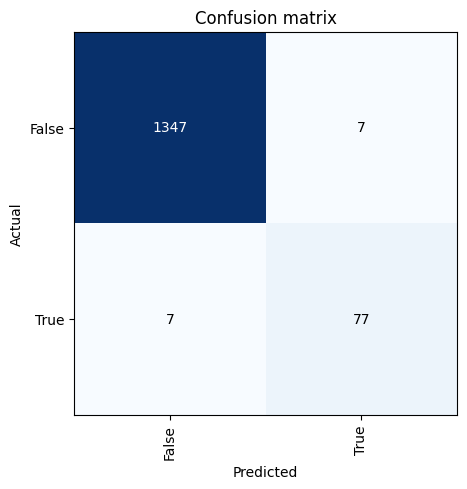

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### MLP with 500 genes as features

In [28]:
with open("../Data/variable_genes.txt") as f:
    var_genes = f.read().splitlines()
len(var_genes)

500

#### Define training and validation split

In [29]:
X = df[var_genes].reset_index() # Input features
y = df["macrophage"]  # Output target
X_train, X_val, y_train, y_val = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.2, \
                                                  stratify=y, random_state=21)

In [30]:
train_idx = X_train[:,0].astype(int)
val_idx = X_val[:,0].astype(int)
splits = (L(train_idx.tolist()), L(val_idx.tolist()))

#### Model parameters

In [31]:
EPOCHS = 2
BATCH_SIZE = 64
LEARNING_RATE = 0.01
NUM_FEATURES = len(var_genes)
NUM_CLASSES = 2

#### Dataloaders

In [32]:
# Define a DataLoaders object to feed data into the model, batch size 64
dls = TabularPandas(
    df, splits=splits,
    cont_names=var_genes,
    y_names='macrophage',
    y_block = CategoryBlock(),
).dataloaders(path=".", bs=BATCH_SIZE)

In [37]:
# Initialize the model
F1_Score= F1Score()
learn = tabular_learner(dls, metrics=[accuracy, F1_Score], layers=[100,100])

#### Tune learning rate

SuggestedLRs(slide=0.03981071710586548, valley=0.0012022644514217973)

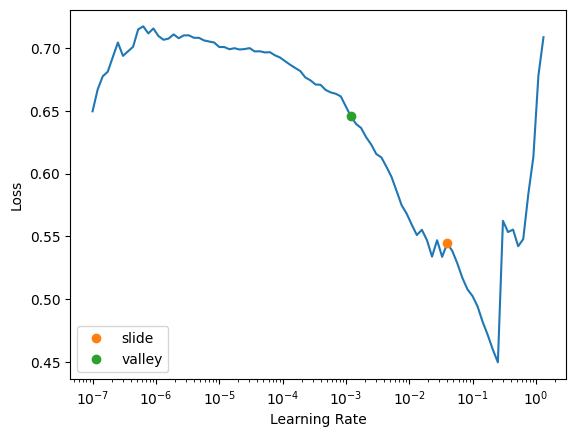

In [38]:
# Identify appropriate learning rate
learn.lr_find(suggest_funcs=(slide, valley))

#### Train model

In [39]:
learn.fit(2, lr=0.01)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.113873,0.061029,0.988873,0.906977,00:03
1,0.041401,0.052745,0.987483,0.890244,00:03


#### Confusion matrix

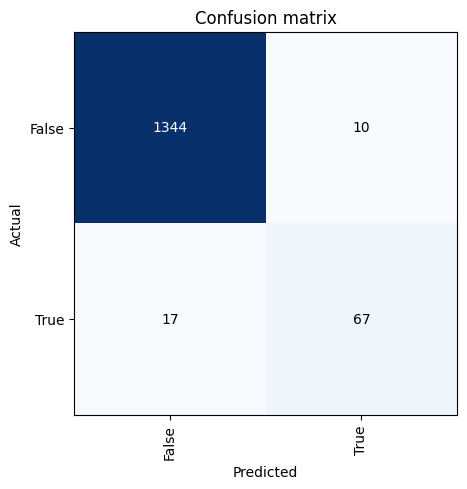

In [95]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()